### data2a - 120416_0229
*Regularization

### data2a - 120116_1200
* run with cleaned dataset, just on damage location, 256x256, ft 8 batch size, 88s per epoch, theano backend
* saved history, created metrics plots
* noted that rmsprop results in higher top layer accuracy for initial fit - closer to 70%
* loss: 0.6640 - acc: 0.7273 - val_loss: 0.5893 - val_acc: 0.7836

### data2 - 112916_1200
* run without discards, just on damage location 256x256, 16 batch size, 80s per epoch, theano backend
* loss: 0.6776 - acc: 0.7151 - val_loss: 0.7998 - val_acc: 0.6928

In [3]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [5]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1# activity_l2, l1, activity_l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

# only import if using tf backend
# import tensorflow as tf
# tf.python.control_flow_ops = tf

In [6]:
def load_vgg16(crop=True, weights_path='../vgg16_weights.h5'):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    return model

In [7]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16(crop=True)
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, # reduced batch size to 16
                                            class_mode=None, 
                                            shuffle=False) 
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [27]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print( 'epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [40]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout()
           
    print( "Best Model:" )
    print_best_model_results(hist)

In [23]:
# load saved data and train a small, fully-connected model
def train_categorical_model():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax')) # upped to 3 and activation softmax

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
    
    # optimizer='rmsprop'
    # optimizers.SGD(lr=0.0001, momentum=0.9)
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [1]:
def finetune_categorical_model():
    # Build the VGG16 Network (again)
    model = load_vgg16()
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base    
    new_model = Sequential()
    new_model.add(model)

    # CONCATENATE THE TWO MODELS
    new_model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False


    new_model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = new_model.fit_generator(train_generator,
                        steps_per_epoch=len(train_generator)//8,
                        epochs=nb_epoch,
                        validation_data=validation_generator,
                        validation_steps=len(validation_generator)//8,
                        verbose=1,
                        callbacks=[checkpoint])
    
    with open(location+'/history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [60]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    print(pred_labels)
    
    print( '')
    print( classification_report(labels, pred_labels))
    print( '')
    cm = confusion_matrix(labels, pred_labels)
    sns.heatmap(cm, annot=True)

In [15]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = raw_input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Inputs

In [16]:
# path to the model weights file
location = 'data2a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [17]:
d2_model, d2_history = train_categorical_model()

FileNotFoundError: [Errno 2] No such file or directory: 'data2a/bottleneck_features_train.npy'

In [18]:
ft_d2_model, ft_d2_history = finetune_categorical_model()

OSError: Unable to open file (unable to open file: name = 'data2a/top_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Try:
* more aggresive data augmentation
* more aggressive dropout
* use of L1 and L2 regularization (also known as "weight decay")
* fine-tuning one more convolutional block (alongside greater regularization)
* use  LR reduce callback
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

### Second Run - With Regularization

In [19]:
# do not rerun!!
save_bottleneck_features(location)

Found 979 images belonging to 3 classes.


c:\Users\umang\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 171 images belonging to 3 classes.


In [24]:
d2_model, d2_history = train_categorical_model()

Epoch 1/50
62/62 [==============================] - 6s 87ms/step - loss: 6.2728 - accuracy: 0.3978 - val_loss: 6.1374 - val_accuracy: 0.5029

Epoch 00001: val_accuracy improved from -inf to 0.50292, saving model to data2a\top_model_weights.h5
Epoch 2/50
62/62 [==============================] - 5s 80ms/step - loss: 6.1282 - accuracy: 0.4729 - val_loss: 6.0586 - val_accuracy: 0.5205

Epoch 00002: val_accuracy improved from 0.50292 to 0.52047, saving model to data2a\top_model_weights.h5
Epoch 3/50
62/62 [==============================] - 4s 72ms/step - loss: 6.0357 - accuracy: 0.5090 - val_loss: 6.0049 - val_accuracy: 0.5205

Epoch 00003: val_accuracy did not improve from 0.52047
Epoch 4/50
62/62 [==============================] - 5s 76ms/step - loss: 5.9601 - accuracy: 0.5596 - val_loss: 5.9657 - val_accuracy: 0.5789

Epoch 00004: val_accuracy improved from 0.52047 to 0.57895, saving model to data2a\top_model_weights.h5
Epoch 5/50
62/62 [==============================] - 5s 77ms/step - l

In [25]:
ft_d2_model, ft_d2_history = finetune_categorical_model()

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


c:\Users\umang\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
15/15 [==============================] - 30s 2s/step - loss: 5.6721 - accuracy: 0.5692 - val_loss: 5.2747 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to data2a\ft_model.h5
Epoch 2/50
15/15 [==============================] - 33s 2s/step - loss: 5.7271 - accuracy: 0.4507 - val_loss: 5.1142 - val_accuracy: 0.6875

Epoch 00002: val_accuracy improved from 0.62500 to 0.68750, saving model to data2a\ft_model.h5
Epoch 3/50
15/15 [==============================] - 35s 2s/step - loss: 5.5106 - accuracy: 0.5615 - val_loss: 5.3020 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.68750 to 0.75000, saving model to data2a\ft_model.h5
Epoch 4/50
15/15 [==============================] - 42s 3s/step - loss: 5.3149 - accuracy: 0.7187 - val_loss: 5.8851 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.75000
Epoch 5/50
15/15 [==============================] - 45s 3s/step - loss: 5.5585 - accuracy: 0.5723 -

## Model evaluation

### First Run - Without Regularization

Best Model:
epoch: 42 , val_acc: 0.7017543911933899 , val_loss: 5.339884281158447


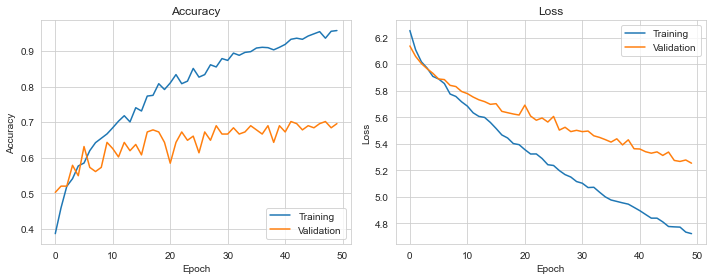

In [28]:
plot_metrics(d2_history)

Best Model:
epoch: 6 , val_acc: 0.875 , val_loss: 5.241354942321777


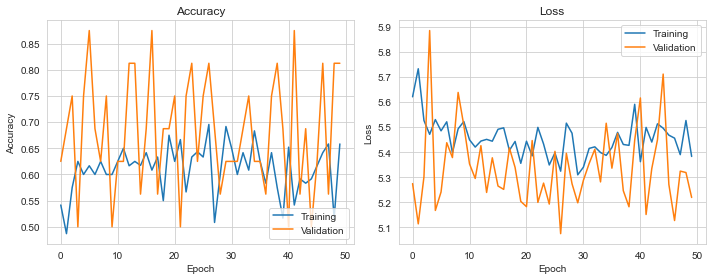

In [29]:
plot_metrics(ft_d2_history)

## Second Run - Metrics

Best Model:
epoch: 42 , val_acc: 0.7017543911933899 , val_loss: 5.339884281158447


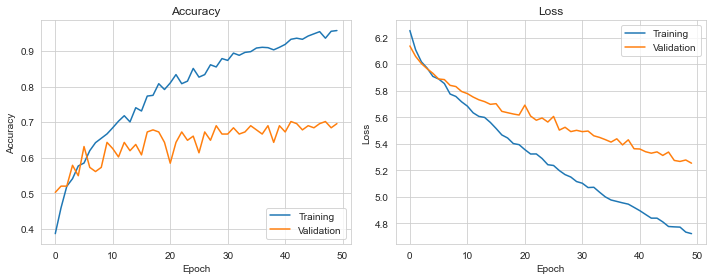

In [30]:
plot_metrics(d2_history)

Best Model:
epoch: 6 , val_acc: 0.875 , val_loss: 5.241354942321777


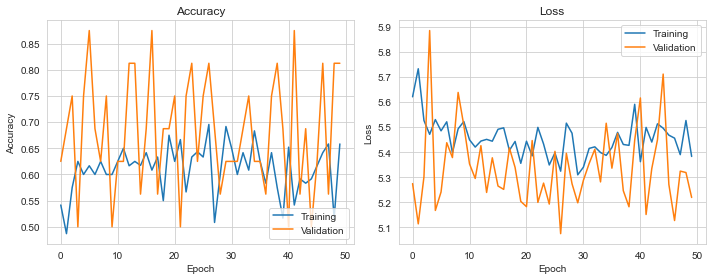

In [31]:
plot_metrics(ft_d2_history)

You can then use keras.models.load_model(filepath) to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [53]:
ft_d2_model2 = load_model('data2a/ft_model.h5')

In [54]:
validation_samples

[73, 50, 48]

In [61]:
validation_labels = np.array([0] * validation_samples[0] +  [1] * validation_samples[1] + [2] * validation_samples[2])
print(len(validation_labels))
evaluate_categorical_model(ft_d2_model, validation_data_dir, validation_labels)

171
Found 171 images belonging to 3 classes.


c:\Users\umang\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[[5 0 0 ... 0 1 0]
  [5 0 6 ... 3 6 0]
  [6 0 6 ... 6 0 0]
  ...
  [2 0 3 ... 6 6 0]
  [2 0 6 ... 6 6 0]
  [1 0 5 ... 0 0 0]]

 [[7 0 5 ... 0 7 0]
  [7 0 3 ... 0 1 0]
  [7 0 3 ... 0 1 0]
  ...
  [2 0 3 ... 0 4 0]
  [2 0 6 ... 0 7 0]
  [1 0 5 ... 0 0 0]]

 [[3 0 6 ... 4 3 0]
  [3 5 4 ... 4 3 0]
  [0 0 4 ... 0 2 0]
  ...
  [3 1 3 ... 1 1 0]
  [3 0 3 ... 1 1 0]
  [3 0 0 ... 0 0 0]]

 ...

 [[2 0 2 ... 0 2 0]
  [2 0 3 ... 0 0 0]
  [1 0 3 ... 0 0 0]
  ...
  [1 0 6 ... 0 0 0]
  [0 0 4 ... 0 1 0]
  [0 0 0 ... 0 2 0]]

 [[4 0 2 ... 0 6 0]
  [3 0 4 ... 0 6 0]
  [3 0 4 ... 3 6 0]
  ...
  [3 0 3 ... 0 4 0]
  [3 0 3 ... 0 3 0]
  [0 0 6 ... 0 4 0]]

 [[6 0 5 ... 0 0 0]
  [6 0 6 ... 0 1 0]
  [7 0 7 ... 0 1 0]
  ...
  [5 0 0 ... 6 2 0]
  [5 0 0 ... 6 1 0]
  [5 0 0 ... 0 1 0]]]



ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

# Load Model Point

In [69]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print( "Best Model:" )
    print_best_model_results(hist)

In [44]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print( '')
    print( classification_report(validation_labels, pred_labels))
    print( '')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [45]:
ft_model = load_model('data2a/ft_model.h5')

In [46]:
with open('data2a/top_history.txt') as f:    
    top_history = json.load(f)

In [62]:
with open('data2a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [48]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

Found 171 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 1 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 0 2 0 0 0 1 0 2
 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 2 2 1 1 1 1 1 1 2 1 2 0 1 0 1 1 0 1 2 1
 0 0 0 1 1 0 1 0 1 1 1 1 2 0 0 2 2 2 2 1 0 2 2 2 2 2 2 0 2 2 2 0 0 2 1 2 2
 1 1 2 0 2 2 1 1 2 2 2 1 0 2 1 2 2 2 2 0 2 2 2]

              precision    recall  f1-score   support

           0       0.73      0.82      0.77        73
           1       0.63      0.62      0.63        50
           2       0.78      0.65      0.70        48

    accuracy                           0.71       171
   macro avg       0.71      0.70      0.70       171
weighted avg       0.71      0.71      0.71       171




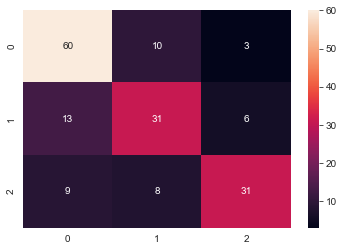

In [63]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

In [66]:
with open('data2a/top_history.txt') as f:    
    top_history = json.load(f)

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout()

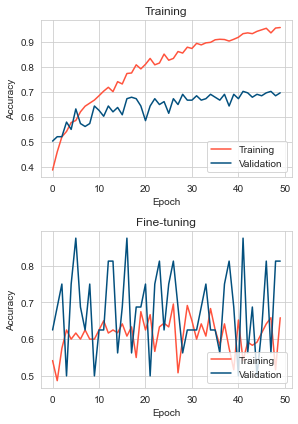

In [67]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 42 , val_acc: 0.7017543911933899 , val_loss: 5.339884281158447


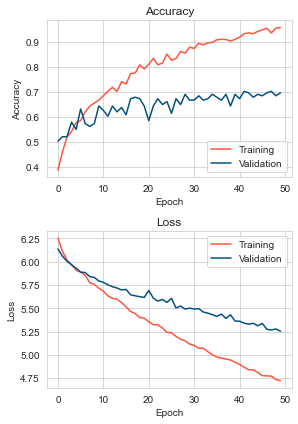

In [70]:
plot_metrics(top_history)

Best Model:
epoch: 6 , val_acc: 0.875 , val_loss: 5.241354942321777


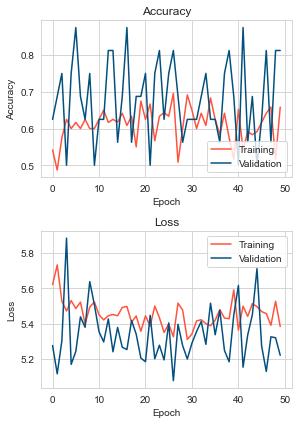

In [71]:
plot_metrics(ft_history)

In [72]:
heatmap_labels = ['Front', 'Rear', 'Side']

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

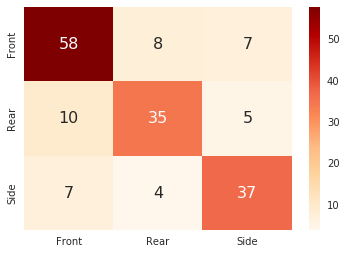

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

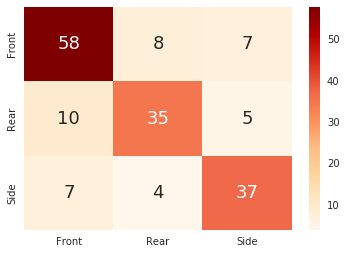

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

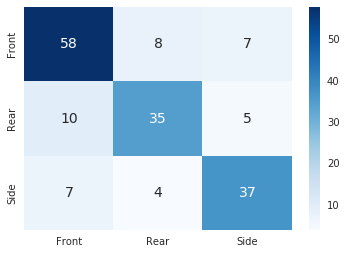

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

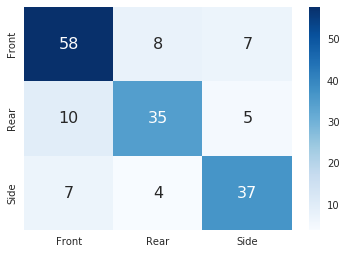

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

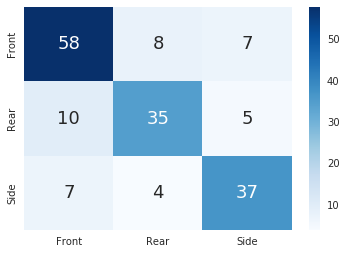

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Looking at Edge Cases

In [74]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [75]:
front1 = get_edge_cases(ft_model, 'data2a/validation/00-front/', 0, 1) # true front, predicted rear - 8
front2 = get_edge_cases(ft_model, 'data2a/validation/00-front/', 0, 2) # true front, predicted side - 7

In [76]:
rear1 = get_edge_cases(ft_model, 'data2a/validation/01-rear/', 1, 0) # true rear, predicted front - 10
rear2 = get_edge_cases(ft_model, 'data2a/validation/01-rear/', 1, 2) # true rear, predicted side - 5

In [77]:
side1 = get_edge_cases(ft_model, 'data2a/validation/02-side/', 2, 0) # true side, predicted front - 7
side2 = get_edge_cases(ft_model, 'data2a/validation/02-side/', 2, 1) # true side, predicted rear - 4

In [78]:
len(front1) == 8, len(front2) == 7, len(rear1) == 10, len(rear2) == 5, len(side1) == 7, len(side2) == 4

(False, False, False, False, False, False)

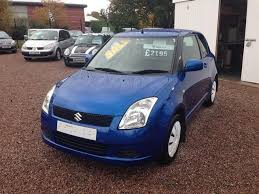

c to continue, q to quitc


In [44]:
view_images('data2a/validation/00-front/', front1)

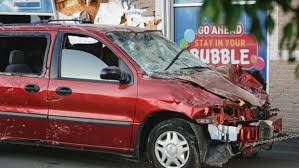

c to continue, q to quitc


In [45]:
view_images('data2a/validation/00-front/', front2)

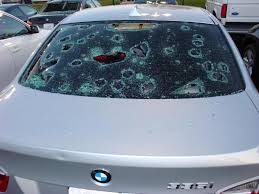

c to continue, q to quitc


In [47]:
view_images('data2a/validation/01-rear/', rear1)

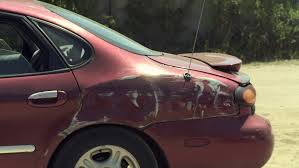

c to continue, q to quitc


In [48]:
view_images('data2a/validation/01-rear/', rear2)

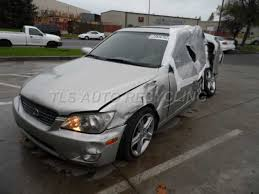

c to continue, q to quitc


In [50]:
view_images('data2a/validation/02-side/', side1)

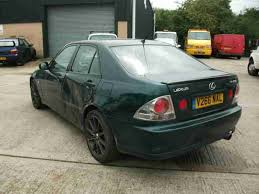

c to continue, q to quitc


In [53]:
view_images('data2a/validation/02-side/', side2)

https://keras.io/visualization/

In [79]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(ft_d2_model2).create(prog='dot', format='svg'))

ModuleNotFoundError: No module named 'keras.utils.visualize_util'